In [22]:
# !pip install speechbrain
# !pip install ruamel_yaml
# !pip install --upgrade ruamel.yaml --ignore-installed ruamel.yaml

# https://pytorch.org/docs/stable/generated/torch.nn.PixelShuffle.html 
# self.conv = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
# kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding),
# PixelShuffle(upscale_factor),
# nn.InstanceNorm2d(num_features=out_channels)) 
# !pip install jiwer

In [6]:
import speechbrain as sb
import torch
import torchaudio
from torchaudio.datasets import LIBRISPEECH
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from speechbrain.pretrained import EncoderDecoderASR
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from jiwer import wer

In [7]:
model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", 
                                       savedir="pretrained_models/asr-crdnn-rnnlm-librispeech",run_opts={"device":"cuda"},freeze_params=True)

In [8]:
encoder = model.hparams.encoder

In [9]:
val_dataset = LIBRISPEECH(".", url= 'dev-clean',download=True)
train_dataset = LIBRISPEECH(".",download=True)
test_dataset = LIBRISPEECH(".",url= 'test-clean',download=True)
# dataset1 = MNIST(".",download=True)

In [10]:
def collate(batch):
    """waveform, sample_rate, transcript, speaker_id"""
    waveforms = [b[0].permute([1,0]) for b in batch]
    waveforms = pad_sequence(waveforms,batch_first=True)
    waveforms = waveforms.squeeze()
    input_len = torch.FloatTensor([b[0].shape[1] for b in batch])
    input_len /= torch.max(input_len)
    sampling_rates = torch.FloatTensor([b[1] for b in batch])
    transcript = [b[2] for b in batch]
    speaker_id = torch.LongTensor([b[3] for b in batch])
    
    return waveforms,input_len,sampling_rates,transcript,speaker_id
    

In [11]:
train_dataLoader = DataLoader(train_dataset,batch_size=5,shuffle=True,collate_fn=collate)
val_dataLoader = DataLoader(val_dataset,batch_size=5,shuffle=False,collate_fn=collate)
test_dataLoader = DataLoader(test_dataset,batch_size=5,shuffle=False,collate_fn=collate)
# train_dataloader = DataLoader(dataset1,batch_size=5,shuffle=True,collate_fn=collate)

In [12]:
# for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(train_dataLoader,start=1):
#     print(speaker_id)
#     break

# highwat network
- adopted from https://github.com/kefirski/pytorch_Highway.git

In [13]:
class Highway(nn.Module):
    def __init__(self, size, num_layers, f):

        super(Highway, self).__init__()

        self.num_layers = num_layers

        self.nonlinear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])

        self.linear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])

        self.gate = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])

        self.f = f

    def forward(self, x):
        """
            :param x: tensor with shape of [batch_size, size]
            :return: tensor with shape of [batch_size, size]
            applies σ(x) ⨀ (f(G(x))) + (1 - σ(x)) ⨀ (Q(x)) transformation | G and Q is affine transformation,
            f is non-linear transformation, σ(x) is affine transformation with sigmoid non-linearition
            and ⨀ is element-wise multiplication
            """

        for layer in range(self.num_layers):
            gate = torch.sigmoid(self.gate[layer](x))

            nonlinear = self.f(self.nonlinear[layer](x))
            linear = self.linear[layer](x)

            x = gate * nonlinear + (1 - gate) * linear

        return x

In [14]:
class SpecsReconstruction(nn.Module):
    
    def __init__(self,input_features,num_blocks,hidden_size,out_feature=40):
        super().__init__()
        self.input_features = input_features
        self.num_blocks = num_blocks
        self.out_feature = out_feature
        
        self.linear1 = nn.Linear(input_features,hidden_size) 
        self.relu1 = nn.ReLU()
        self.highway = Highway(hidden_size,num_blocks,nn.ReLU())
        self.linear2 = nn.Linear(hidden_size,out_feature)
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.highway(x)
        x = self.linear2(x)
        return x
        
            

In [10]:
h0 = SpecsReconstruction(2560,5,100,40).cuda()


In [ ]:
# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(h0.parameters(),lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2)
# epochs = 30
path = "h0_states.pth"
def load_model_parameter(path):
    try:
        print("Loading states")
        state = torch.load(path)
        start_epoch = state["epoch"]
        train_losses = state["train_losses"]
        val_losses = state["val_losses"]
        model_dict = state["model_dict"]
        optimizer = state["optimizer"]
        scheduler = state["scheduler"]
        print("successifully loaded states")
        return start_epoch,train_losses,val_losses,model_dict,optimizer,scheduler
    except:
        print("failed to load states")
        return None

def save_model_parameters(path,state_dict):
    torch.save(state_dict,path)
    print("states at {} epoch saved".format(state_dict["epoch"]))
    
states = load_model_parameter(path)
if states is not None:
    start_epoch,train_losses,val_losses,model_dict,optimizer_dict,scheduler_dict = states
    h0.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)
    scheduler.load_state_dict(scheduler_dict)

In [ ]:
train_loss = []
val_loss = []
min_loss = np.Infinity

for i in range(epochs):
    t = []
    l = []
    h0.train()
    for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(train_dataLoader,start=1):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        optimizer.zero_grad()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            block_0 = encoder.model.CNN.block_0(targets)
        block_0 = block_0.reshape(block_0.shape[0],block_0.shape[1],-1)
        out = h0(block_0)
        loss = criterion(targets,out)
        loss.backward()
        optimizer.step()
        if (j+1) % 100 == 0:
            print("epoch:{}/{}".format(i+1,epochs,j))
        t.append(loss.item())
    av_t = sum(t)/len(t)
    print("epoch:{}/{},Train loss:{}".format(i+1,epochs,av_t))
    train_loss.append(av_t)
    del waveform
    del input_len
    # validation loop
    h0.eval()
    for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(val_dataLoader,start=1):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            block_0 = encoder.model.CNN.block_0(targets)
            block_0 = block_0.reshape(block_0.shape[0],block_0.shape[1],-1)
            out = h0(block_0)
            loss = criterion(targets,out)
            if (j+1) % 100 == 0:
                print("epoch:{}/{}".format(i+1,epochs,j))
            l.append(loss.item())
    av_l = sum(l)/len(l)
    print("epoch:{}/{},Val loss:{}".format(i+1,epochs,av_l))
    val_loss.append(av_l)
    if av_l < min_loss:
        min_loss = av_l
        torch.save(h0,"best_model_0")
        
    state_dict = {
    "epoch":i,
    "train_losses":train_loss,
    "val_losses":val_loss,
    "model_dict":h0.state_dict(),
    "optimizer":optimizer.state_dict(),
    "scheduler":scheduler.state_dict()
    }
    save_model_parameters("h0_states.pth",state_dict)
    scheduler.step(av_l)
    

In [ ]:
h0_1 = SpecsReconstruction(5120,5,100,40).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(h0_1.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2)
epochs = 30
stretch = torchaudio.transforms.TimeStretch()

In [ ]:
path = "h0_1_states.pth"
def load_model_parameter(path):
    try:
        print("Loading states")
        state = torch.load(path)
        start_epoch = state["epoch"]
        train_losses = state["train_losses"]
        val_losses = state["val_losses"]
        model_dict = state["model_dict"]
        optimizer = state["optimizer"]
        scheduler = state["scheduler"]
        print("successifully loaded states")
        return start_epoch,train_losses,val_losses,model_dict,optimizer,scheduler
    except:
        print("failed to load states")
        return None

def save_model_parameters(path,state_dict):
    torch.save(state_dict,path)
    print("states at {} epoch saved".format(state_dict["epoch"]))
    
states = load_model_parameter(path)
if states is not None:
    start_epoch,train_losses,val_losses,model_dict,optimizer_dict,scheduler_dict = states
    h0_1.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)
    scheduler.load_state_dict(scheduler_dict)

In [ ]:
train_loss = []
val_loss = []
min_loss = np.Infinity

for i in range(start_epoch,epochs):
    t = []
    l = []
    h0_1.train()
    for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(train_dataLoader,start=1):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        optimizer.zero_grad()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            conv_1 = encoder.model.CNN.block_0.conv_1(targets)
            norm_1 = encoder.model.CNN.block_0.norm_1(conv_1)
            norm_1 =  norm_1.reshape( norm_1.shape[0], norm_1.shape[1],-1)
        out = h0_1(norm_1)
        loss = criterion(targets,out)
        loss.backward()
        optimizer.step()
        if (j+1) % 100 == 0:
            print("epoch:{}/{}".format(i+1,epochs,j))
        t.append(loss.item())
    av_t = sum(t)/len(t)
    print("epoch:{}/{},Train loss:{}".format(i+1,epochs,av_t))
    train_loss.append(av_t)
    del waveform
    del input_len
    # validation loop
    h0_1.eval()
    for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(val_dataLoader,start=1):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            conv_1 = encoder.model.CNN.block_0.conv_1(targets)
            norm_1 = encoder.model.CNN.block_0.norm_1(conv_1)
            norm_1 =  norm_1.reshape( norm_1.shape[0], norm_1.shape[1],-1)
            out = h0_1(norm_1)
            loss = criterion(targets,out)
            if (j+1) % 100 == 0:
                print("epoch:{}/{}".format(i+1,epochs,j))
            l.append(loss.item())
    av_l = sum(l)/len(l)
    print("epoch:{}/{},Val loss:{}".format(i+1,epochs,av_l))
    val_loss.append(av_l)
    if av_l < min_loss:
        min_loss = av_l
        torch.save(h0_1,"best_model_01")
        
    state_dict = {
    "epoch":i,
    "train_losses":train_loss,
    "val_losses":val_loss,
    "model_dict":h0_1.state_dict(),
    "optimizer":optimizer.state_dict(),
    "scheduler":scheduler.state_dict()
    }
    save_model_parameters("h0_1_states.pth",state_dict)
    scheduler.step(av_l)

In [ ]:
# del h0
h1 = SpecsReconstruction(2560,5,100,40).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(h1.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2)
epochs = 30

In [ ]:
train_loss = []
val_loss = []
min_loss = np.Infinity

for i in range(epochs):
    t = []
    l = []
    h1.train()
    for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(train_dataLoader,start=1):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        optimizer.zero_grad()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            block_0 = encoder.model.CNN.block_0(targets)
            block_1 = encoder.model.CNN.block_1( block_0)
            block_1 = block_1.reshape(block_1.shape[0],block_1.shape[1],-1)
        out = h1(block_1)
        loss = criterion(targets,out)
        loss.backward()
        optimizer.step()
        if (j+1) % 100 == 0:inputs
            print("epoch:{}/{}".format(i+1,epochs,j))
        t.append(loss.item())
    av_t = sum(t)/len(t)
    print("epoch:{}/{},Train loss:{}".format(i+1,epochs,av_t))
    train_loss.append(av_t)
    del waveform
    del input_len
    # validation loop
    h1.eval()
    for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(val_dataLoader,start=1):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            block_0 = encoder.model.CNN.block_0(targets)
            block_1 = encoder.model.CNN.block_1(block_0)
            block_1 = block_1.reshape(block_1.shape[0],block_1.shape[1],-1)
            out = h1(block_1)
            loss = criterion(targets,out)
            if (j+1) % 100 == 0:
                print("epoch:{}/{}".format(i+1,epochs,j))
            l.append(loss.item())
    av_l = sum(l)/len(l)
    print("epoch:{}/{},Val loss:{}".format(i+1,epochs,av_l))
    val_loss.append(av_l)
    if av_l < min_loss:
        min_loss = av_l
        torch.save(h1,"best_model_1")
        
    state_dict = {
    "epoch":i,
    "train_losses":train_loss,
    "val_losses":val_loss,
    "model_dict":h1.state_dict(),
    "optimizer":optimizer.state_dict(),
    "scheduler":scheduler.state_dict()
    }
    save_model_parameters("h1_states.pth",state_dict)
    scheduler.step(av_l)
    

In [ ]:
h1_1 = SpecsReconstruction(5120,5,100,40).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(h1_1.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2)
epochs = 30
stretch = torchaudio.transforms.TimeStretch()

In [ ]:
path = "h1_1_states.pth"
def load_model_parameter(path):
    try:
        print("Loading states")
        state = torch.load(path)
        start_epoch = state["epoch"]
        train_losses = state["train_losses"]
        val_losses = state["val_losses"]
        model_dict = state["model_dict"]
        optimizer = state["optimizer"]
        scheduler = state["scheduler"]
        print("successifully loaded states")
        return start_epoch,train_losses,val_losses,model_dict,optimizer,scheduler
    except:
        print("failed to load states")
        return None

def save_model_parameters(path,state_dict):
    torch.save(state_dict,path)
    print("states at {} epoch saved".format(state_dict["epoch"]))
    
states = load_model_parameter(path)
if states is not None:
    start_epoch,train_losses,val_losses,model_dict,optimizer_dict,scheduler_dict = states
    h1_1.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)
    scheduler.load_state_dict(scheduler_dict)
else:
    start_epoch = 0

In [ ]:
train_loss = []
val_loss = []
min_loss = np.Infinity

for i in range(start_epoch,epochs):
    t = []
    l = []
    h1_1.train()
    for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(train_dataLoader,start=1):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        optimizer.zero_grad()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            block_0 = encoder.model.CNN.block_0(targets)
            conv_1 = encoder.model.CNN.block_1.conv_1(block_0)
            norm_1 = encoder.model.CNN.block_1.norm_1(conv_1)
            norm_1 =  norm_1.reshape( norm_1.shape[0], norm_1.shape[1],-1)
        out = h1_1(norm_1)
        loss = criterion(targets,out)
        loss.backward()
        optimizer.step()
        if (j+1) % 100 == 0:
            print("epoch:{}/{}".format(i+1,epochs,j))
        t.append(loss.item())
    av_t = sum(t)/len(t)
    print("epoch:{}/{},Train loss:{}".format(i+1,epochs,av_t))
    train_loss.append(av_t)
    del waveform
    del input_len
    # validation loop
    h1_1.eval()
    for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(val_dataLoader,start=1):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            block_0 = encoder.model.CNN.block_0(targets)
            conv_1 = encoder.model.CNN.block_1.conv_1(block_0)
            norm_1 = encoder.model.CNN.block_1.norm_1(conv_1)
            norm_1 =  norm_1.reshape( norm_1.shape[0], norm_1.shape[1],-1)
            out = h1_1(norm_1)
            loss = criterion(targets,out)
            if (j+1) % 100 == 0:
                print("epoch:{}/{}".format(i+1,epochs,j))
            l.append(loss.item())
    av_l = sum(l)/len(l)
    print("epoch:{}/{},Val loss:{}".format(i+1,epochs,av_l))
    val_loss.append(av_l)
    if av_l < min_loss:
        min_loss = av_l
        torch.save(h1_1,"best_model_11")
        
    state_dict = {
    "epoch":i,
    "train_losses":train_loss,
    "val_losses":val_loss,
    "model_dict":h1_1.state_dict(),
    "optimizer":optimizer.state_dict(),
    "scheduler":scheduler.state_dict()
    }
    save_model_parameters("h1_1_states.pth",state_dict)
    scheduler.step(av_l)

## Transcription class

In [68]:
class Transcribe:
    def __init__(self):
        self.model = model
    def __call__(self,x,lens):
        return self.forward(x,lens)
    def forward(self,x,lens):
        predicted_words = []
        with torch.no_grad():
            out = self.model.hparams.encoder.model(x)
            out,_ = self.model.hparams.decoder(out,lens)
            predicted_words = [self.model.hparams.tokenizer.decode_ids(o) for o in out]
            return predicted_words

### Model 0

In [69]:
# h0 = SpecsReconstruction(2560,5,100,40).cuda()
h0 = torch.load("best_model_0")

In [70]:
transcribe = Transcribe()

In [71]:
h0.eval()
word_error_rate = 0
for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(test_dataLoader):
        waveform = waveform.cuda()
        input_len = input_len.cuda()
        with torch.no_grad():
            specs = encoder.compute_features(waveform)
            targets = encoder.normalize(specs,input_len)
            block_0 = encoder.model.CNN.block_0(targets)
            block_0 = block_0.reshape(block_0.shape[0],block_0.shape[1],-1)
            out = h0(block_0)
            trans = transcribe(out,input_len)
            for i in range(len(trans)):
                word_error_rate += wer(trans[i],transcript[i])
            print("{}/{}".format(j,len(test_dataLoader)))

0/524
1/524
2/524
3/524
4/524
5/524
6/524
7/524
8/524
9/524
10/524
11/524
12/524
13/524
14/524
15/524
16/524
17/524
18/524
19/524
20/524
21/524
22/524
23/524
24/524
25/524
26/524
27/524
28/524
29/524
30/524
31/524
32/524
33/524
34/524
35/524
36/524
37/524
38/524
39/524
40/524
41/524
42/524
43/524
44/524
45/524
46/524
47/524
48/524
49/524
50/524
51/524
52/524
53/524
54/524
55/524
56/524
57/524
58/524
59/524
60/524
61/524
62/524
63/524
64/524
65/524
66/524
67/524
68/524
69/524
70/524
71/524
72/524
73/524
74/524
75/524
76/524
77/524
78/524
79/524
80/524
81/524
82/524
83/524
84/524
85/524
86/524
87/524
88/524
89/524
90/524
91/524
92/524
93/524
94/524
95/524
96/524
97/524
98/524
99/524
100/524
101/524
102/524
103/524
104/524
105/524
106/524
107/524
108/524
109/524
110/524
111/524
112/524
113/524
114/524
115/524
116/524
117/524
118/524
119/524
120/524
121/524
122/524
123/524
124/524
125/524
126/524
127/524
128/524
129/524
130/524
131/524
132/524
133/524
134/524
135/524
136/524
137/524
138/52

In [90]:
print("World error rate:{}".format(word_error_rate/5/len(test_dataLoader)))

World error rate:0.06468178009155047


# model 0 1

In [73]:
h0_1 = torch.load("best_model_01")

In [74]:
h0_1.eval()
word_error_rate1 = 0
for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(test_dataLoader):
    waveform = waveform.cuda()
    input_len = input_len.cuda()
    with torch.no_grad():
        specs = encoder.compute_features(waveform)
        targets = encoder.normalize(specs,input_len)
        conv_1 = encoder.model.CNN.block_0.conv_1(targets)
        norm_1 = encoder.model.CNN.block_0.norm_1(conv_1)
        norm_1 =  norm_1.reshape( norm_1.shape[0], norm_1.shape[1],-1)
        out = h0_1(norm_1)
        trans = transcribe(out,input_len)
        for i in range(len(trans)):
            word_error_rate1 += wer(trans[i],transcript[i])
        print("{}/{}".format(j,len(test_dataLoader)))

0/524
1/524
2/524
3/524
4/524
5/524
6/524
7/524
8/524
9/524
10/524
11/524
12/524
13/524
14/524
15/524
16/524
17/524
18/524
19/524
20/524
21/524
22/524
23/524
24/524
25/524
26/524
27/524
28/524
29/524
30/524
31/524
32/524
33/524
34/524
35/524
36/524
37/524
38/524
39/524
40/524
41/524
42/524
43/524
44/524
45/524
46/524
47/524
48/524
49/524
50/524
51/524
52/524
53/524
54/524
55/524
56/524
57/524
58/524
59/524
60/524
61/524
62/524
63/524
64/524
65/524
66/524
67/524
68/524
69/524
70/524
71/524
72/524
73/524
74/524
75/524
76/524
77/524
78/524
79/524
80/524
81/524
82/524
83/524
84/524
85/524
86/524
87/524
88/524
89/524
90/524
91/524
92/524
93/524
94/524
95/524
96/524
97/524
98/524
99/524
100/524
101/524
102/524
103/524
104/524
105/524
106/524
107/524
108/524
109/524
110/524
111/524
112/524
113/524
114/524
115/524
116/524
117/524
118/524
119/524
120/524
121/524
122/524
123/524
124/524
125/524
126/524
127/524
128/524
129/524
130/524
131/524
132/524
133/524
134/524
135/524
136/524
137/524
138/52

In [89]:
print("World error rate:{}".format(word_error_rate1/5/len(test_dataLoader)))

World error rate:0.06728262906765783


In [76]:
h1 = torch.load("best_model_1")

In [79]:
h1.eval()
word_error_rate2 = 0
for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(test_dataLoader,start=1):
    waveform = waveform.cuda()
    input_len = input_len.cuda()
    with torch.no_grad():
        specs = encoder.compute_features(waveform)
        targets = encoder.normalize(specs,input_len)
        block_0 = encoder.model.CNN.block_0(targets)
        block_1 = encoder.model.CNN.block_1( block_0)
        block_1 = block_1.reshape(block_1.shape[0],block_1.shape[1],-1)
        out = h1(block_1)
        trans = transcribe(out,input_len)
        for i in range(len(trans)):
            word_error_rate2 += wer(trans[i],transcript[i])
        print("{}/{}".format(j,len(test_dataLoader)))

1/524
2/524
3/524
4/524
5/524
6/524
7/524
8/524
9/524
10/524
11/524
12/524
13/524
14/524
15/524
16/524
17/524
18/524
19/524
20/524
21/524
22/524
23/524
24/524
25/524
26/524
27/524
28/524
29/524
30/524
31/524
32/524
33/524
34/524
35/524
36/524
37/524
38/524
39/524
40/524
41/524
42/524
43/524
44/524
45/524
46/524
47/524
48/524
49/524
50/524
51/524
52/524
53/524
54/524
55/524
56/524
57/524
58/524
59/524
60/524
61/524
62/524
63/524
64/524
65/524
66/524
67/524
68/524
69/524
70/524
71/524
72/524
73/524
74/524
75/524
76/524
77/524
78/524
79/524
80/524
81/524
82/524
83/524
84/524
85/524
86/524
87/524
88/524
89/524
90/524
91/524
92/524
93/524
94/524
95/524
96/524
97/524
98/524
99/524
100/524
101/524
102/524
103/524
104/524
105/524
106/524
107/524
108/524
109/524
110/524
111/524
112/524
113/524
114/524
115/524
116/524
117/524
118/524
119/524
120/524
121/524
122/524
123/524
124/524
125/524
126/524
127/524
128/524
129/524
130/524
131/524
132/524
133/524
134/524
135/524
136/524
137/524
138/524
139/

In [88]:
print("World error rate:{}".format(word_error_rate2/5/len(test_dataLoader)))

World error rate:0.07345462276525248


In [82]:
h1_1 = torch.load("best_model_11")
h1_1.eval()
word_error_rate3 = 0
for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(test_dataLoader,start=1):
    waveform = waveform.cuda()
    input_len = input_len.cuda()
    with torch.no_grad():
        specs = encoder.compute_features(waveform)
        targets = encoder.normalize(specs,input_len)
        block_0 = encoder.model.CNN.block_0(targets)
        conv_1 = encoder.model.CNN.block_1.conv_1(block_0)
        norm_1 = encoder.model.CNN.block_1.norm_1(conv_1)
        norm_1 =  norm_1.reshape( norm_1.shape[0], norm_1.shape[1],-1)
        out = h1_1(norm_1)
        trans = transcribe(out,input_len)
        for i in range(len(trans)):
            word_error_rate3 += wer(trans[i],transcript[i])
        print("{}/{}".format(j,len(test_dataLoader)))

1/524
2/524
3/524
4/524
5/524
6/524
7/524
8/524
9/524
10/524
11/524
12/524
13/524
14/524
15/524
16/524
17/524
18/524
19/524
20/524
21/524
22/524
23/524
24/524
25/524
26/524
27/524
28/524
29/524
30/524
31/524
32/524
33/524
34/524
35/524
36/524
37/524
38/524
39/524
40/524
41/524
42/524
43/524
44/524
45/524
46/524
47/524
48/524
49/524
50/524
51/524
52/524
53/524
54/524
55/524
56/524
57/524
58/524
59/524
60/524
61/524
62/524
63/524
64/524
65/524
66/524
67/524
68/524
69/524
70/524
71/524
72/524
73/524
74/524
75/524
76/524
77/524
78/524
79/524
80/524
81/524
82/524
83/524
84/524
85/524
86/524
87/524
88/524
89/524
90/524
91/524
92/524
93/524
94/524
95/524
96/524
97/524
98/524
99/524
100/524
101/524
102/524
103/524
104/524
105/524
106/524
107/524
108/524
109/524
110/524
111/524
112/524
113/524
114/524
115/524
116/524
117/524
118/524
119/524
120/524
121/524
122/524
123/524
124/524
125/524
126/524
127/524
128/524
129/524
130/524
131/524
132/524
133/524
134/524
135/524
136/524
137/524
138/524
139/

In [87]:
print("World error rate:{}".format(word_error_rate3/5/len(test_dataLoader)))

World error rate:0.06771345263494656


In [84]:
word_error_rate4 = 0
for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(test_dataLoader,start=1):
    waveform = waveform.cuda()
    input_len = input_len.cuda()
    with torch.no_grad():
        trans,_ = model.transcribe_batch(waveform,input_len)
        for i in range(len(trans)):
            word_error_rate4 += wer(trans[i],transcript[i])
        print("{}/{}".format(j,len(test_dataLoader)))

1/524
2/524
3/524
4/524
5/524
6/524
7/524
8/524
9/524
10/524
11/524
12/524
13/524
14/524
15/524
16/524
17/524
18/524
19/524
20/524
21/524
22/524
23/524
24/524
25/524
26/524
27/524
28/524
29/524
30/524
31/524
32/524
33/524
34/524
35/524
36/524
37/524
38/524
39/524
40/524
41/524
42/524
43/524
44/524
45/524
46/524
47/524
48/524
49/524
50/524
51/524
52/524
53/524
54/524
55/524
56/524
57/524
58/524
59/524
60/524
61/524
62/524
63/524
64/524
65/524
66/524
67/524
68/524
69/524
70/524
71/524
72/524
73/524
74/524
75/524
76/524
77/524
78/524
79/524
80/524
81/524
82/524
83/524
84/524
85/524
86/524
87/524
88/524
89/524
90/524
91/524
92/524
93/524
94/524
95/524
96/524
97/524
98/524
99/524
100/524
101/524
102/524
103/524
104/524
105/524
106/524
107/524
108/524
109/524
110/524
111/524
112/524
113/524
114/524
115/524
116/524
117/524
118/524
119/524
120/524
121/524
122/524
123/524
124/524
125/524
126/524
127/524
128/524
129/524
130/524
131/524
132/524
133/524
134/524
135/524
136/524
137/524
138/524
139/

In [86]:
print("World error rate:{}".format(word_error_rate4/5/len(test_dataLoader)))

World error rate:0.06677564656410001


In [95]:
from speechbrain.pretrained import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")
score, prediction =verification.verify_files("speechbrain/spkrec-ecapa-voxceleb/example1.wav", "speechbrain/spkrec-ecapa-voxceleb/example2.flac")

In [128]:
wav,sr = torchaudio.load("example1.wav")

In [129]:
import matplotlib.pyplot as plt

torch.Size([1, 52173])

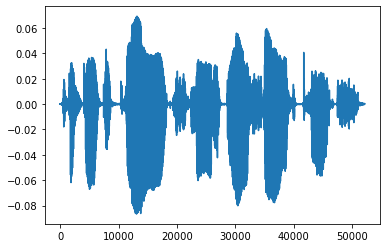

In [130]:
plt.plot(wav.reshape(-1))
wav.shape

In [209]:
wav = wav.cuda()
input_len = torch.FloatTensor([1.0]).cuda()
with torch.no_grad():
    specs = encoder.compute_features(wav)
    targets = encoder.normalize(specs,input_len)
    block_0 = encoder.model.CNN.block_0(targets)
    block_0 = block_0.reshape(block_0.shape[0],block_0.shape[1],-1)
    out = h0(block_0)

In [175]:
out.shape
out.permute([0,2,1])

tensor([[[-3.6289, -3.8508, -3.6348,  ..., -3.0047, -2.6919, -3.0465],
         [-2.6995, -2.9194, -2.5090,  ..., -2.2184, -2.2175, -2.6312],
         [-1.9627, -1.8744, -1.7339,  ..., -1.8063, -2.1418, -2.3433],
         ...,
         [-2.0504, -1.7467, -1.8110,  ..., -1.4124, -1.2631, -1.5580],
         [-2.0562, -1.5912, -1.7146,  ..., -1.0853, -1.1753, -1.4252],
         [-1.7762, -1.3342, -1.3647,  ..., -0.7943, -1.0362, -0.8829]]],
       device='cuda:0')

In [218]:
transform = torchaudio.transforms.GriffinLim(n_fft=78)
# transform = torchaudio.transforms.InverseSpectrogram(win_length=400,hop_length=10,window_fn=torch.hamming_window)

In [216]:
out_wav = transform(out.permute([0,2,1]).cpu())

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torchaudio/functional/functional.py:180: UserWarning: The use of pseudo complex type in inverse_spectrogram is now deprecated. Please migrate to native complex type by using a complex tensor as input. If the input is generated via spectrogram() function or transform, please use return_complex=True as an argument to that function. Please refer to https://github.com/pytorch/audio/issues/1337 for more details about torchaudio's plan to migrate to native complex type.
  "The use of pseudo complex type in inverse_spectrogram is now deprecated. "


RuntimeError: Tensor must have a last dimension of size 2

torch.Size([1, 12714])


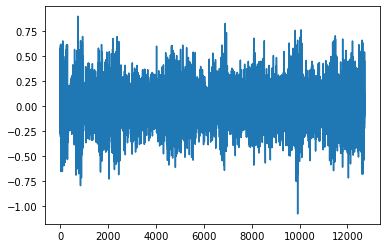

In [ ]:
print(out_wav.shape)
plt.plot(out_wav.reshape(-1))


In [193]:
with torch.no_grad():
    trans,_ = model.transcribe_batch(out_wav.cuda(),torch.FloatTensor([1.0]).cuda())
    print(trans)
#     for i in range(len(trans)):
        
#     print("{}/{}".format(j,len(test_dataLoader)))

['PROMPTLY']


In [194]:
with torch.no_grad():
    trans,_ = model.transcribe_batch(wav.cuda(),torch.FloatTensor([1.0]).cuda())
    print(trans)

['THE BIRCH CANOE SLID ON THE SMOOTH PLANKS']


In [195]:
h1_1 = torch.load("best_model_11")
h1_1.eval()
word_error_rate3 = 0
for j,(waveform, input_len ,sample_rate, transcript, speaker_id) in enumerate(test_dataLoader,start=1):
    waveform = waveform.cuda()
    input_len = input_len.cuda()
    with torch.no_grad():
        specs = encoder.compute_features(waveform)
        targets = encoder.normalize(specs,input_len)
        block_0 = encoder.model.CNN.block_0(targets)
        conv_1 = encoder.model.CNN.block_1.conv_1(block_0)
        norm_1 = encoder.model.CNN.block_1.norm_1(conv_1)
        norm_1 =  norm_1.reshape( norm_1.shape[0], norm_1.shape[1],-1)
        out = h1_1(norm_1)
        trans = transcribe(out,input_len)
        for i in range(len(trans)):
            word_error_rate3 += wer(trans[i],transcript[i])
        # print("{}/{}".format(j,len(test_dataLoader)))
        break

In [204]:
specs.shape


torch.Size([5, 1044, 40])

In [202]:
out_wav = transform(torch.abs(specs.permute([0,2,1]).cpu()))

In [205]:
out_wav.shape

torch.Size([5, 40677])

In [207]:
with torch.no_grad():
    trans,_ = model.transcribe_batch(out_wav.cuda(),input_len.cuda())
    print(trans)

['SYMPATHY ACCORDINGLY', 'ACCORDING TO SYMPATHY', 'ACCORDING TO DRINK', "IT'S ABSOLUTELY ABSOLUTELY", "IT'S ABSOLUTELY DESERTED"]


In [208]:
with torch.no_grad():
    trans,_ = model.transcribe_batch(waveform.cuda(),input_len.cuda())
    print(trans)

['HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FAT AND SAUCE', 'STUFFED INTO YOU HIS BELLY COUNSELLED I', 'AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS', 'OH BERTIE ANY GOOD IN YOUR MIND', 'NUMBER DEN FRESH NELLIE IS WAITING ON YOU GOOD NIGHT HUSBAND']


In [1]:
encoder

NameError: name 'encoder' is not defined

In [222]:
encoder.compute_features.compute_fbanks

Filterbank()

In [5]:
encoder

LengthsCapableSequential(
  (compute_features): Fbank(
    (compute_STFT): STFT()
    (compute_fbanks): Filterbank()
    (compute_deltas): Deltas()
    (context_window): ContextWindow()
  )
  (normalize): InputNormalization()
  (model): CRDNN(
    (CNN): Sequential(
      (block_0): CNN_Block(
        (conv_1): Conv2d(
          (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
        )
        (norm_1): LayerNorm(
          (norm): LayerNorm((40, 128), eps=1e-05, elementwise_affine=True)
        )
        (act_1): LeakyReLU(negative_slope=0.01)
        (conv_2): Conv2d(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        )
        (norm_2): LayerNorm(
          (norm): LayerNorm((40, 128), eps=1e-05, elementwise_affine=True)
        )
        (act_2): LeakyReLU(negative_slope=0.01)
        (pooling): Pooling1d(
          (pool_layer): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
        )
        (dro